In [1]:
import pathlib
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cartopy
import elevation
import xarray as xr
from itertools import combinations
from more_itertools import pairwise
from netCDF4 import Dataset
from visualisation_utils import plot_colormap_from_dataset, \
    plot_wind_components_from_dataset, plot_wind_components_from_different_datasets, process_station_txt_file_from_MeteoSwiss, distance_from_coordinates, HigherResPlateCarree

data_path = pathlib.Path("../data")
warnings.filterwarnings('ignore')

# ERA5 Data

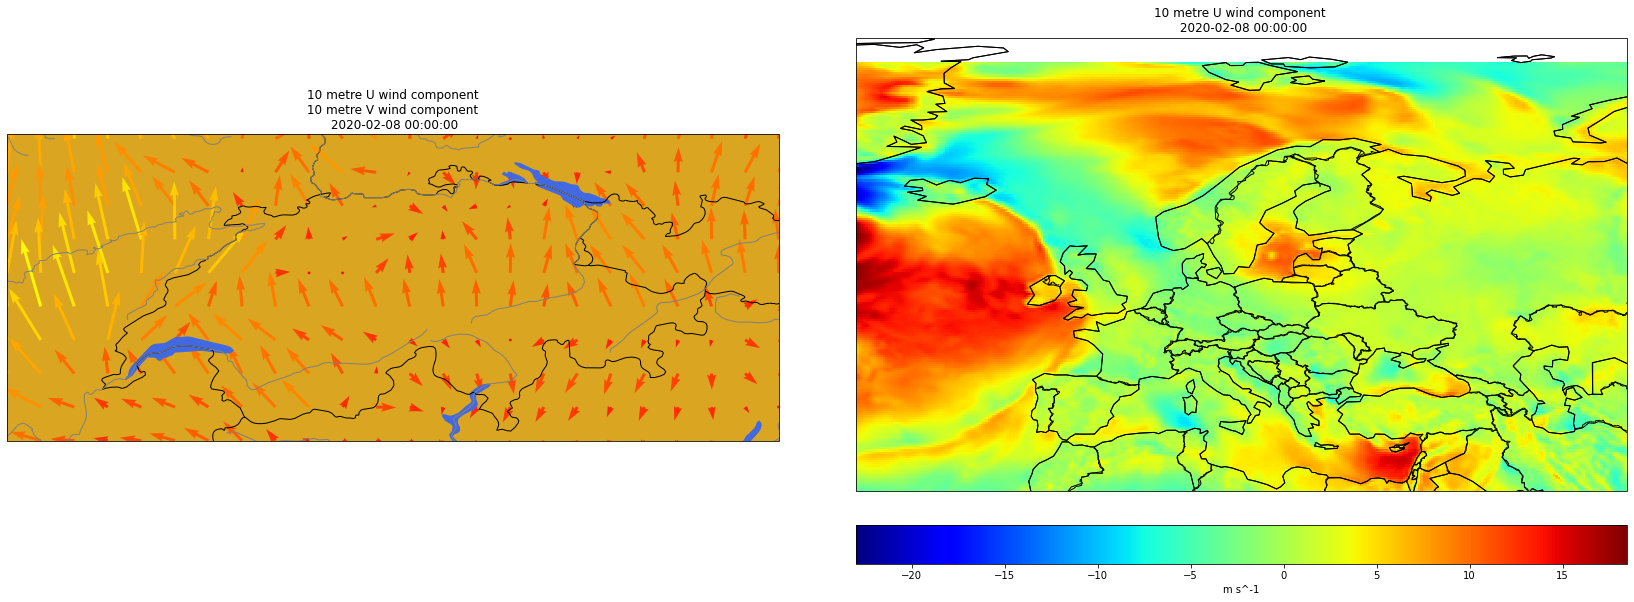

In [2]:
file = data_path.glob('ERA5/*.nc').__next__()
data = Dataset(file, mode='r')  # read the data

range_long = (5.1, 11.2)
range_lat = (45.7, 48.1)

subplot_kw = {'projection': HigherResPlateCarree()}
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw=subplot_kw, figsize=(25,12.5))
fig.subplots_adjust(wspace=0.1, left=0.05, right=0.95)
plot_wind_components_from_dataset(data, 0, 'u10', 'v10',
                                  range_lon=range_long, range_lat=range_lat,
                                  ax=ax1)
plot_colormap_from_dataset(data, 0, 'u10', ax=ax2)
fig.show()

# NASA-GISS-E2-R CMIP5 RCP4.5 Data

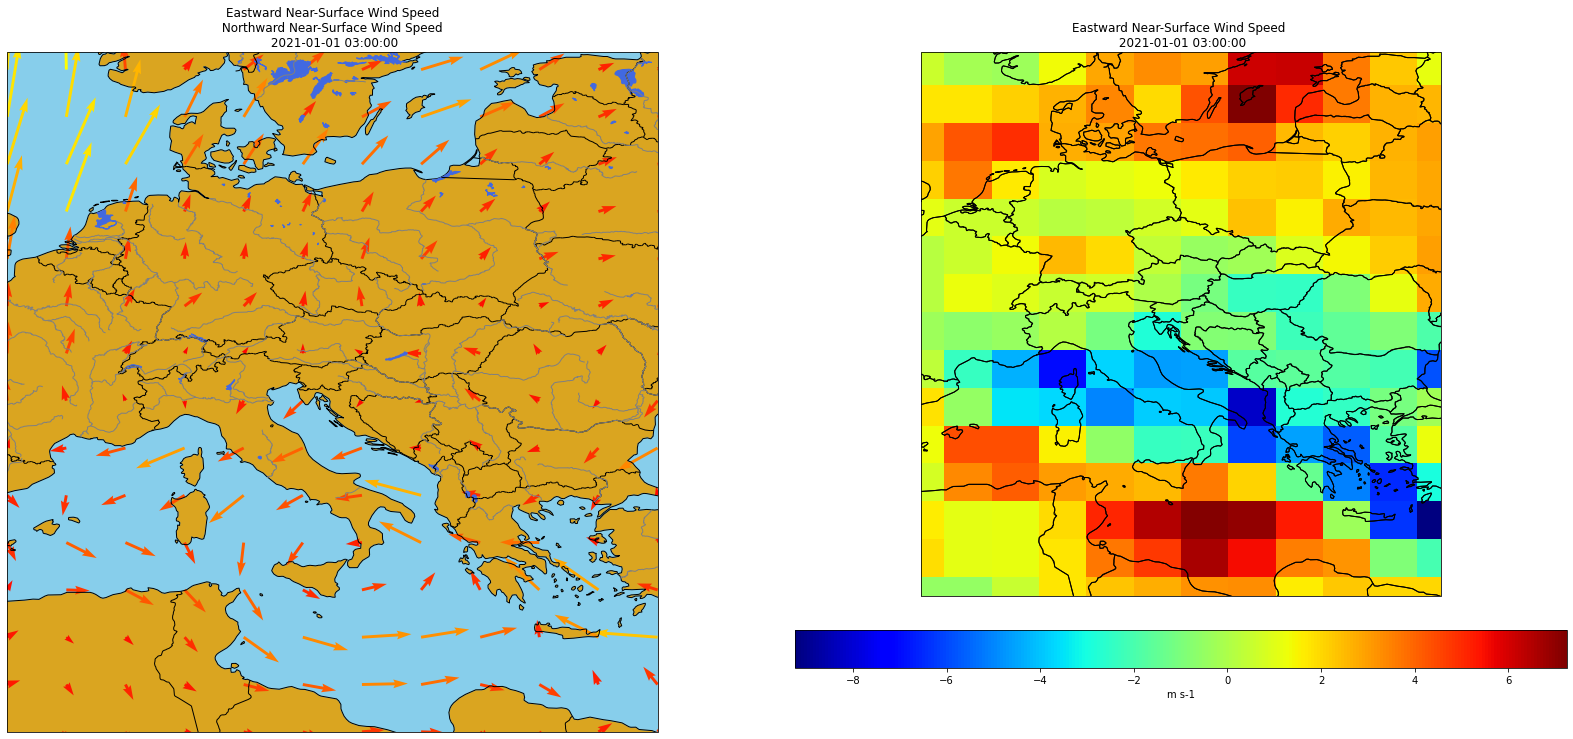

In [3]:
file_uas = data_path.glob("NASA-GISS-E2-R/rcp45/uas*.nc").__next__()
d1 = Dataset(file_uas, mode='r')  # read the data
file_vas = data_path.glob("NASA-GISS-E2-R/rcp45/vas*.nc").__next__()
d2 = Dataset(file_vas, mode='r')

range_long = (0 , 30)
range_lat = (30, 60)

subplot_kw = {'projection': HigherResPlateCarree()}
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw=subplot_kw, figsize=(25, 12.5))
fig.subplots_adjust(wspace=0.1, left=0.05, right=0.95)
plot_wind_components_from_different_datasets(d1, d2, 0, 'uas', 'vas',
                                             range_lon=range_long,
                                             range_lat=range_lat,
                                             ax=ax1)
plot_colormap_from_dataset(d1, 0, 'uas', range_lon=range_long,
                                             range_lat=range_lat, ax=ax2)
fig.show()


# MeteoSwiss Observations

In [4]:
file_obs = pathlib.Path(data_path, 'MS_observations/wind_2016_2021_processed_more_stations.csv')
file_station = pathlib.Path(data_path, 'MS_observations/stations.txt')
obs = pd.read_csv(file_obs)
obs.head(5)

,Unnamed: 0,station,datetime_raw,wind_gust_mps,wind_speed_mps,wind_direction_degrees,theta_radians,u10,v10,date,datetime,station_name,data_source,altitude_m,lon,lat,x_km,y_km
0,0,CIM,2016010100,1.7,0.8,219.0,3.822271,-0.503456,-0.621717,2016-01-01,2016-01-01 00:00:00,Cimetta,MeteoSchweiz,1661,8.783333,46.2,704433.0,117457.0
1,1,CIM,2016010101,3.5,1.5,297.0,5.183628,-1.336510,0.680986,2016-01-01,2016-01-01 01:00:00,Cimetta,MeteoSchweiz,1661,8.783333,46.2,704433.0,117457.0
2,2,CIM,2016010102,1.7,0.7,39.0,0.680678,0.440524,0.544002,2016-01-01,2016-01-01 02:00:00,Cimetta,MeteoSchweiz,1661,8.783333,46.2,704433.0,117457.0
3,3,CIM,2016010103,1.7,0.6,37.0,0.645772,0.361089,0.479181,2016-01-01,2016-01-01 03:00:00,Cimetta,MeteoSchweiz,1661,8.783333,46.2,704433.0,117457.0
4,4,CIM,2016010104,2.2,0.8,315.0,5.497787,-0.565685,0.565685,2016-01-01,2016-01-01 04:00:00,Cimetta,MeteoSchweiz,1661,8.783333,46.2,704433.0,117457.0


<AxesSubplot:xlabel='station'>

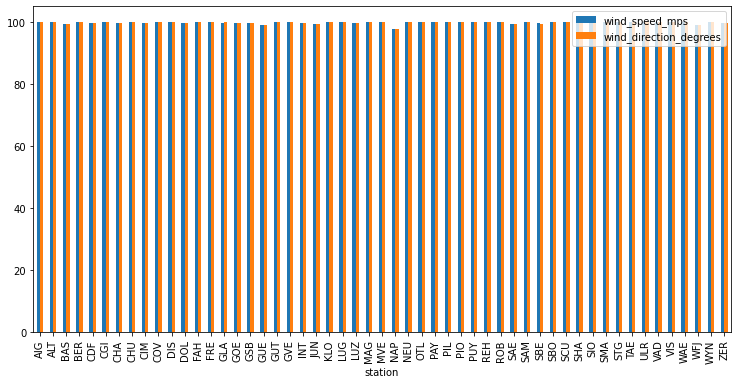

In [5]:
def pct_data_available(x: pd.Series):
    return 100*x.count()/len(x)
obs.groupby('station').agg({'wind_speed_mps': pct_data_available, 'wind_direction_degrees':pct_data_available})\
.plot(kind='bar', figsize=(12.5,6))

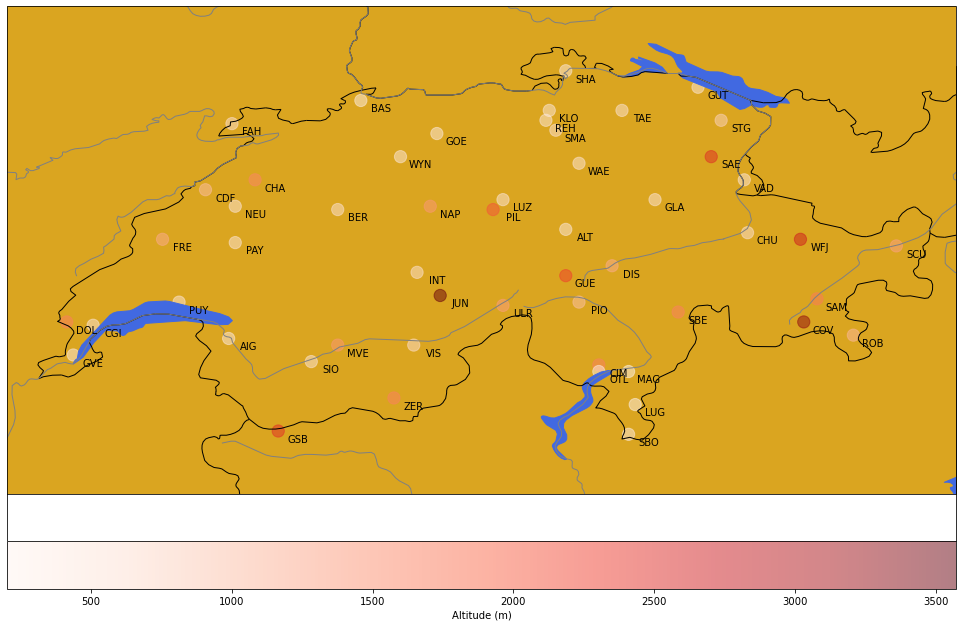

In [6]:
stations=process_station_txt_file_from_MeteoSwiss(file_station)\
.assign(enriched_name = lambda x: x['station_name'] + ' ('+ x['station'] + ')')
def plot_stations(ax, stations_df):
    proj = HigherResPlateCarree()
    ax = plt.axes(projection=proj)
    ax.set_extent([stations.lon.min()-0.3, stations.lon.max()+0.3, stations.lat.min()-0.3, stations.lat.max()+0.3])
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='goldenrod')
    ax.add_feature(cartopy.feature.LAKES.with_scale('10m'), color='royalblue')
    ax.add_feature(cartopy.feature.OCEAN, color='skyblue')
    ax.add_feature(cartopy.feature.BORDERS.with_scale('10m'), color='black')
    ax.add_feature(cartopy.feature.RIVERS.with_scale('10m'), color='grey')
    c_scheme = ax.scatter(x=stations.lon, y=stations.lat,
                s=150,
                c=stations.altitude_m,
                cmap='Reds',
                alpha=0.5,
                transform=HigherResPlateCarree())
    plt.colorbar(c_scheme, location='bottom', pad=0.07,
                 label='Altitude (m)', ax=ax)
    for s, d in stations.groupby('station'):
        ax.text(d.lon+0.1, d.lat-0.04, s, transform=HigherResPlateCarree(),
                fontsize=10, c='black', horizontalalignment='center', verticalalignment='center')
subplot_kw = {'projection': HigherResPlateCarree()}
fig, ax1 = plt.subplots(ncols=1, subplot_kw=subplot_kw, figsize=(17, 12.5))
plot_stations(ax1, stations)
fig.show()

## Wind Speed

Text(0, 0.5, 'wind speed (ms^-1)')

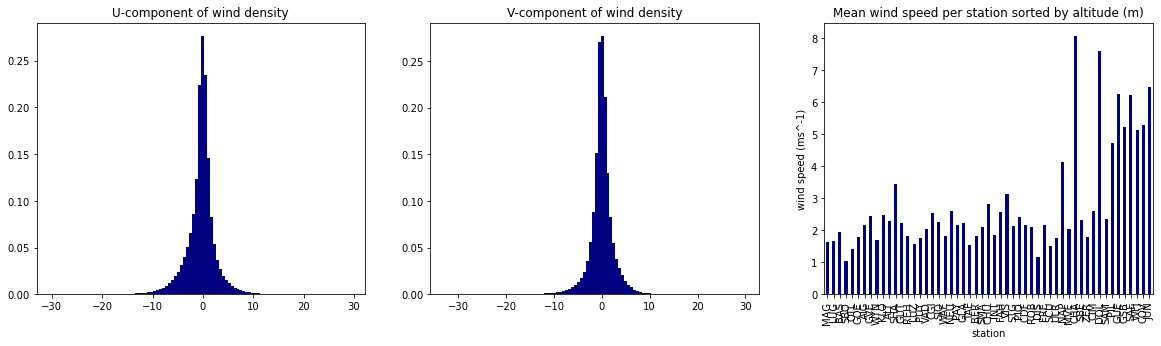

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(20,5))
ax1.hist(obs['u10'], density=True, color='navy', bins=100)
ax1.set_title('U-component of wind density')
ax2.hist(obs['v10'], density=True, color='navy', bins=100)
ax2.set_title('V-component of wind density')
obs.groupby('station').agg({'wind_speed_mps':'mean', 'altitude_m': lambda x: x.unique()})\
.sort_values(by='altitude_m')['wind_speed_mps'].plot(kind='bar', ax=ax3, color='navy')
ax3.set_title('Mean wind speed per station sorted by altitude (m)')
ax3.set_ylabel('wind speed (ms^-1)')

Text(0.5, 1.0, 'Square root wind speed (ms^-1) density')

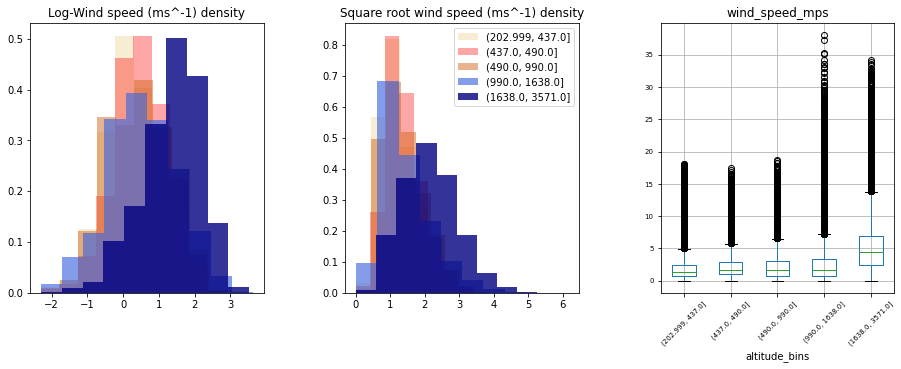

In [21]:
nb_bins = 5
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(15,5))
obs['altitude_bins'] = pd.qcut(obs['altitude_m'],nb_bins)
for (ab, df), c, a in zip(obs.groupby('altitude_bins'), 
                          ['goldenrod', 'red', 'chocolate','royalblue', 'navy'],
                          np.linspace(0.2,0.8,nb_bins)):
    ax1.hist(np.log(df[df['wind_speed_mps']>0]['wind_speed_mps']), density=True, 
             label=ab, color=c, alpha=a)
    ax2.hist(np.sqrt(df['wind_speed_mps']), density=True,
             label=ab, color=c, alpha=a)
obs.boxplot(by='altitude_bins', column=['wind_speed_mps'], ax=ax3, rot=45, fontsize=7)
fig.suptitle('')
ax1.set_title('Log-Wind speed (ms^-1) density')
ax2.legend()
plt.subplots_adjust(wspace=0.35)
ax2.set_title('Square root wind speed (ms^-1) density')

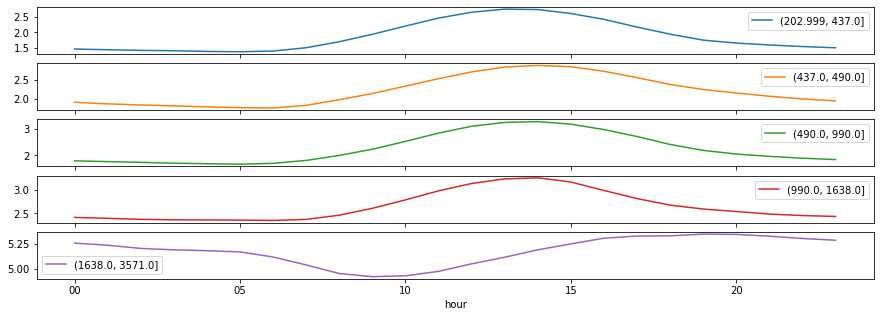

In [9]:
obs = obs.assign(hour = lambda x: x['datetime'].str[-8:])
obs['hour'] = obs['hour'].str[0:2]
obs.groupby(['hour', 'altitude_bins']).agg({'wind_speed_mps':'mean'})['wind_speed_mps'].unstack('altitude_bins').plot(subplots=True,
                                                                                                          sharex=True,
                                                                                                          figsize=(15,5))
plt.legend()

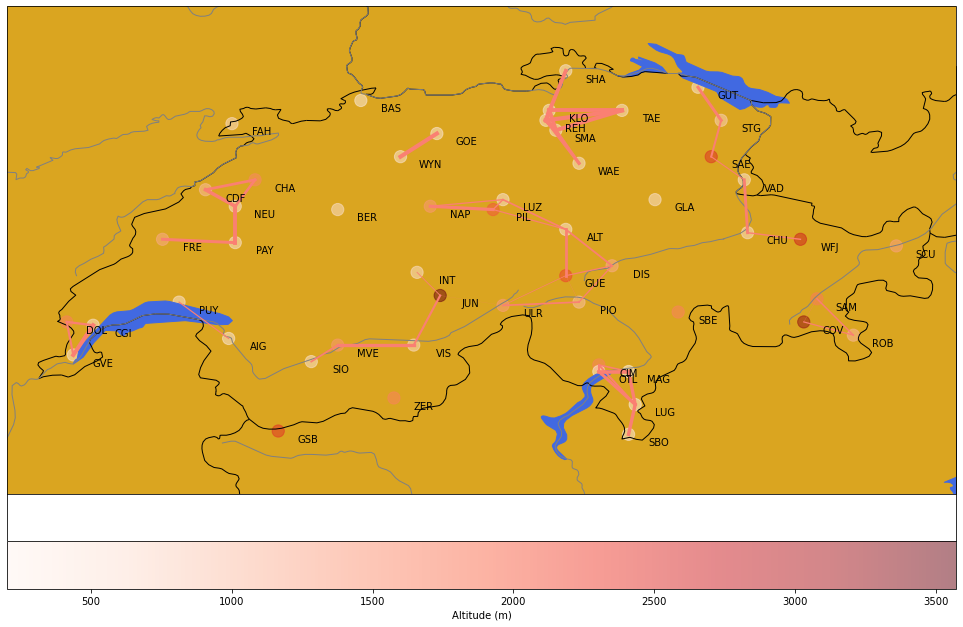

In [10]:
corr_wind_speed_stations = obs.set_index(['station', 'datetime'])['wind_speed_mps'].unstack('station').corr()
def plot_correlation_between_stations(ax, stations_df, corr_df):
    distance_corr_dic = {}
    proj = HigherResPlateCarree()
    ax = plt.axes(projection=proj)
    ax.set_extent([stations.lon.min()-0.3, stations.lon.max()+0.3, stations.lat.min()-0.3, stations.lat.max()+0.3])
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='goldenrod')
    ax.add_feature(cartopy.feature.LAKES.with_scale('10m'), color='royalblue')
    ax.add_feature(cartopy.feature.OCEAN, color='skyblue')
    ax.add_feature(cartopy.feature.BORDERS.with_scale('10m'), color='black')
    ax.add_feature(cartopy.feature.RIVERS.with_scale('10m'), color='grey')
    c_scheme = ax.scatter(x=stations.lon, y=stations.lat,
                s=150,
                c=stations.altitude_m,
                cmap='Reds',
                alpha=0.5,
                transform=HigherResPlateCarree())
    plt.colorbar(c_scheme, location='bottom', pad=0.07,
                 label='Altitude (m)', ax=ax)
    for s1, s2 in combinations(corr_df.columns,2):
        lon1, lat1 = float(stations[stations['station']==s1].lon), float(stations[stations['station']==s1].lat)
        lon2, lat2 = float(stations[stations['station']==s2].lon), float(stations[stations['station']==s2].lat)
        d = distance_from_coordinates((lon1, lat1), (lon2, lat2))
        distance_corr_dic[d] = corr_df.loc[s1, s2]
        if distance_from_coordinates((lon1, lat1), (lon2, lat2))<=30:
            plt.plot([lon1, lon2], [lat1, lat2],
                 linewidth=0.1+5*np.abs(corr_df.loc[s1, s2]),
                 c = 'salmon',
                 transform=HigherResPlateCarree())
    for s, d in stations.groupby('station'):
        ax.text(d.lon+0.15, d.lat-0.04, s, transform=HigherResPlateCarree(),
                fontsize=10, c='black', horizontalalignment='center', verticalalignment='center')
    return distance_corr_dic
subplot_kw = {'projection': HigherResPlateCarree()}
fig, ax1 = plt.subplots(ncols=1, subplot_kw=subplot_kw, figsize=(17, 12.5))
distance_corr_dic = plot_correlation_between_stations(ax1, stations, corr_wind_speed_stations)
fig.show()

<AxesSubplot:xlabel='d_bins', ylabel='correlation'>

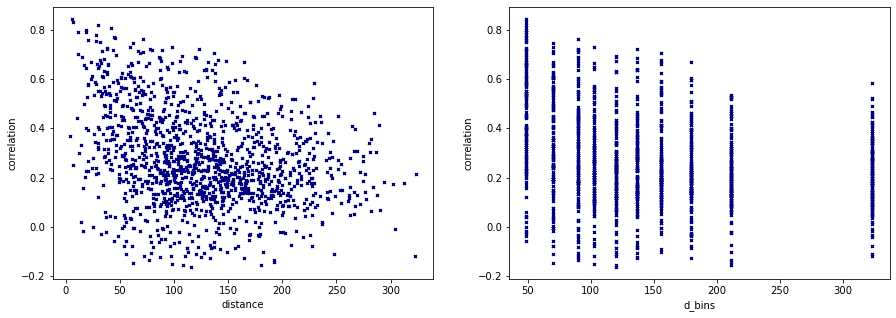

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))
distance_corr_df = pd.DataFrame.from_dict(distance_corr_dic, orient='index').sort_index().reset_index()\
.rename(columns={0:'correlation', 'index': 'distance'})
d_bins = pd.qcut(distance_corr_df['distance'], 10)
distance_corr_df['d_bins'] = d_bins.apply(lambda x: x.right)
distance_corr_df.plot(kind='scatter', x='distance', y='correlation',
                                                           marker='x', s=8, color='navy', ax=ax1)
distance_corr_df.plot(kind='scatter', x='d_bins', y='correlation',
                                                             marker='x', s=8, color='navy', ax=ax2)

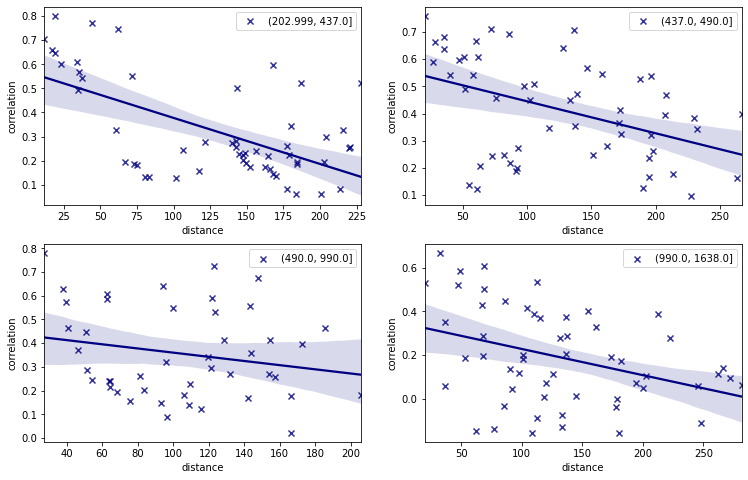

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12.5,8))
distance_corr_dic_per_ab = {}
for ab in sorted(obs.altitude_bins.unique()):
    stations_ab = obs[obs['altitude_bins']==ab]['station'].unique()
    distance_corr_dic_per_ab[ab] = {}
    for s1, s2 in combinations(stations_ab,2):
        lon1, lat1 = float(stations[stations['station']==s1].lon), float(stations[stations['station']==s1].lat)
        lon2, lat2 = float(stations[stations['station']==s2].lon), float(stations[stations['station']==s2].lat)
        d = distance_from_coordinates((lon1, lat1), (lon2, lat2))
        distance_corr_dic_per_ab[ab][d] = corr_wind_speed_stations.loc[s1, s2]
distance_corr_df_per_ab = pd.DataFrame.from_dict(distance_corr_dic_per_ab, orient='columns').sort_index()
for c, ax in zip(distance_corr_df_per_ab.columns, (ax1, ax2, ax3, ax4)):
    sns.regplot(x=distance_corr_df_per_ab.index, y=distance_corr_df_per_ab[c], ax=ax, 
                label=c, color='navy', marker='x')
    ax.legend()
    ax.set_xlabel('distance')
    ax.set_ylabel('correlation')

Wind speed seems impacted by altitude (increasing) and hour in the day (polynomial deg 2 with peak at noon, more or less fat tailed depending on altitude). Log wind speed could be considered Gaussian/Gamma?
Correlation depending on distance between places: not observed, it actually does not look very isotropic nor stationary in space and there could be space-time crossed-effects (JUN station is the highest and the daily wind pattern is different).

## Wind direction

Text(0.5, 1.0, 'Wind direction (rad) distribution per altitude bin')

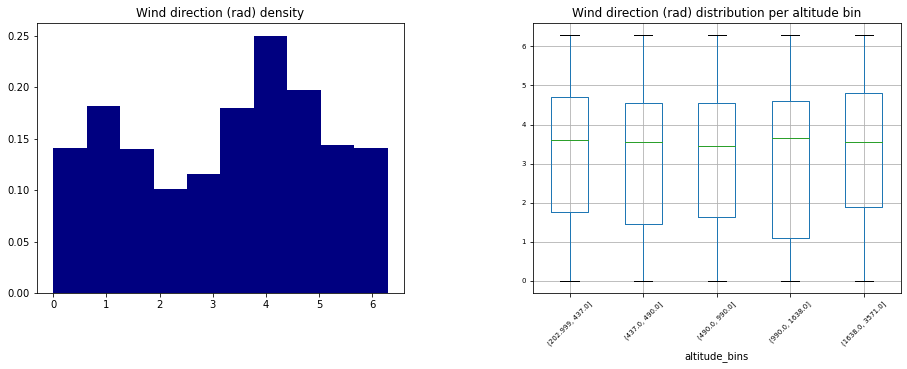

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))
ax1.hist(obs['theta_radians'], density=True, color='navy')
obs.boxplot(by='altitude_bins', column=['theta_radians'], ax=ax2, rot=45, fontsize=7)
fig.suptitle('')
ax1.set_title('Wind direction (rad) density')
plt.subplots_adjust(wspace=0.35)
ax2.set_title('Wind direction (rad) distribution per altitude bin')

Wind direction almost uniform wiht overdispersion for big values, obviously bounded, no effect from the altitude at first sight, although some variation depending on station. Perhaps it comes from the proximity of some stations?

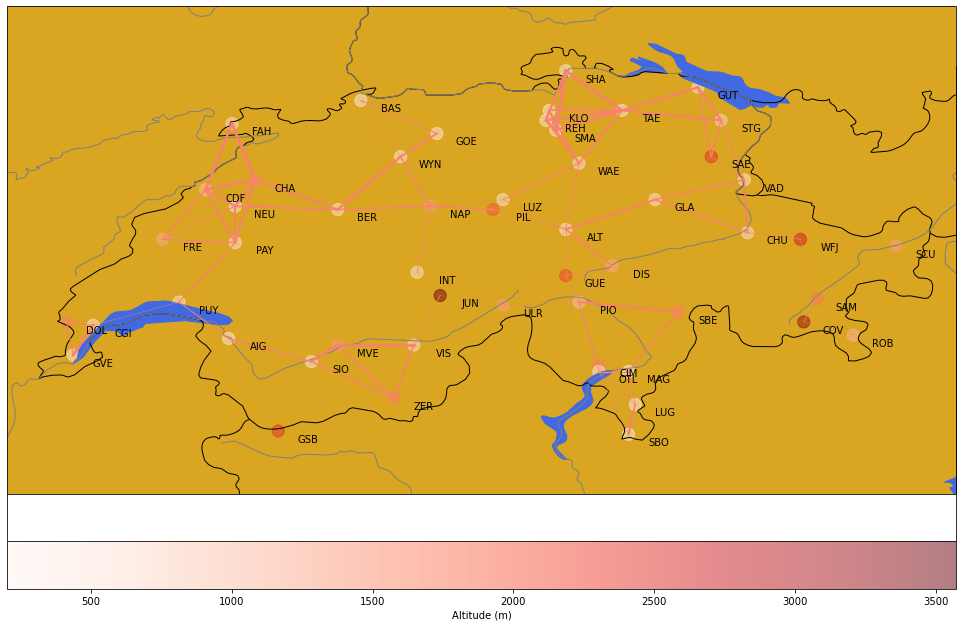

In [14]:
corr_wind_dir = obs.set_index(['station', 'datetime'])['theta_radians'].unstack('station').corr()
def plot_correlation_between_stations(ax, stations_df, corr_df):
    dic_corr_distance={}
    proj = HigherResPlateCarree()
    ax = plt.axes(projection=proj)
    ax.set_extent([stations.lon.min()-0.3, stations.lon.max()+0.3, stations.lat.min()-0.3, stations.lat.max()+0.3])
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='goldenrod')
    ax.add_feature(cartopy.feature.LAKES.with_scale('10m'), color='royalblue')
    ax.add_feature(cartopy.feature.OCEAN, color='skyblue')
    ax.add_feature(cartopy.feature.BORDERS.with_scale('10m'), color='black')
    ax.add_feature(cartopy.feature.RIVERS.with_scale('10m'), color='grey')
    c_scheme = ax.scatter(x=stations.lon, y=stations.lat,
                s=150,
                c=stations.altitude_m,
                cmap='Reds',
                alpha=0.5,
                transform=HigherResPlateCarree())
    plt.colorbar(c_scheme, location='bottom', pad=0.07,
                 label='Altitude (m)', ax=ax)
    for s1, s2 in combinations(corr_df.columns,2):
        lon1, lat1 = float(stations[stations['station']==s1].lon), float(stations[stations['station']==s1].lat)
        lon2, lat2 = float(stations[stations['station']==s2].lon), float(stations[stations['station']==s2].lat)
        d=distance_from_coordinates((lon1, lat1), (lon2, lat2))
        dic_corr_distance[d] = corr_df.loc[s1, s2]
        if d<=40:
            plt.plot([lon1, lon2], [lat1, lat2],
                 linewidth=0.1+5*np.abs(corr_df.loc[s1, s2]),
                 c='salmon',
                 transform=HigherResPlateCarree())
    for s, d in stations.groupby('station'):
        ax.text(d.lon+0.15, d.lat-0.04, s, transform=HigherResPlateCarree(),
                fontsize=10, c='black', horizontalalignment='center', verticalalignment='center')
    return dic_corr_distance
subplot_kw = {'projection': HigherResPlateCarree()}
fig, ax1 = plt.subplots(ncols=1, subplot_kw=subplot_kw, figsize=(17, 12.5))
dic_corr_distance_direction = plot_correlation_between_stations(ax1, stations, corr_wind_dir)
fig.show()

<AxesSubplot:xlabel='d_bins', ylabel='correlation'>

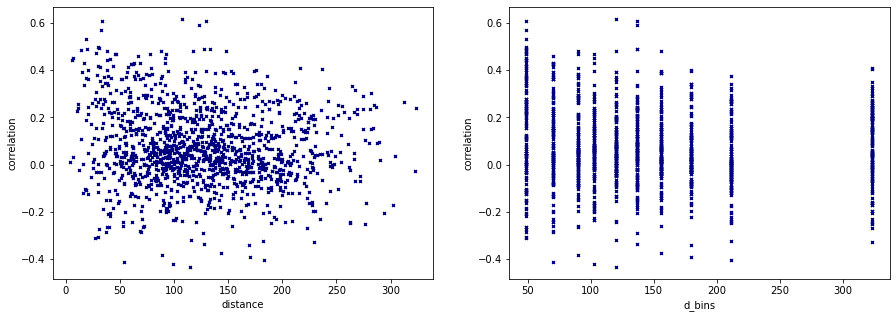

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,5))
distance_corr_df = pd.DataFrame.from_dict(dic_corr_distance_direction, orient='index').sort_index().reset_index()\
.rename(columns={0:'correlation', 'index': 'distance'})
d_bins = pd.qcut(distance_corr_df['distance'], 10)
distance_corr_df['d_bins'] = d_bins.apply(lambda x: x.right)
distance_corr_df.plot(kind='scatter', x='distance', y='correlation',
                                                           marker='x', s=8, color='navy', ax=ax1)
distance_corr_df.plot(kind='scatter', x='d_bins', y='correlation',
                                                             marker='x', s=8, color='navy', ax=ax2)

No isotropy there either

# Topographic covariates

The areas of interest are:
- Europe -30 30 60 80
- Switzerland 5.1 45.7 11.2 48.1

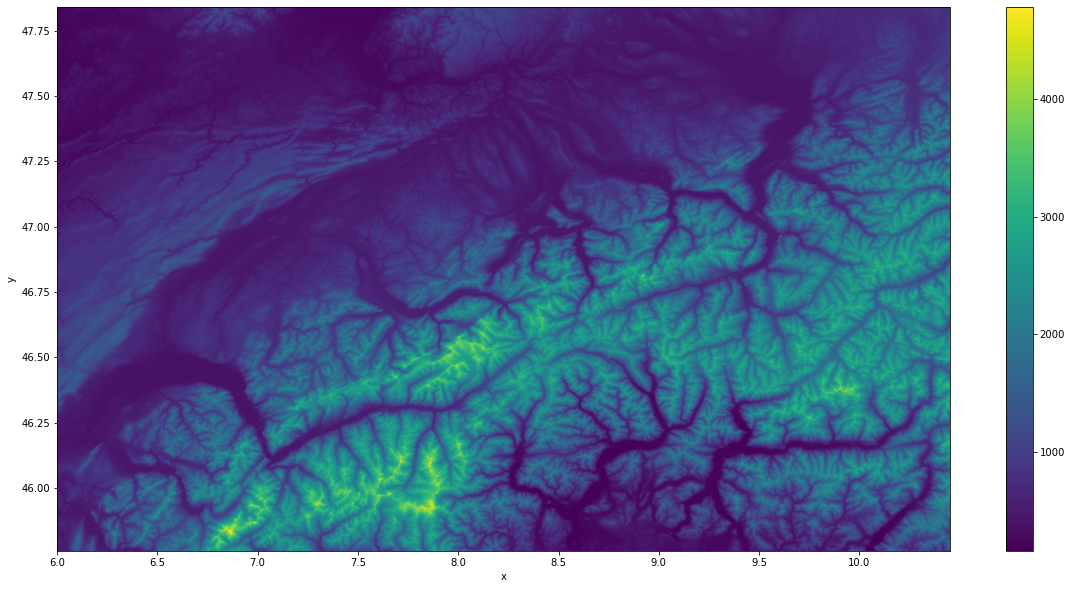

In [16]:
import xarray as xr
dem = xr.open_rasterio("/Users/Boubou/Documents/GitHub/WindDownscaling_EPFL_UNIBE/data/dem/Switzerland-90m-DEM.tif")
dem = dem.isel(band=0, drop=True)
dem.plot(figsize=(20,10))

Reprojecting coordinates from WGS84 to UTM to obtain units of meters


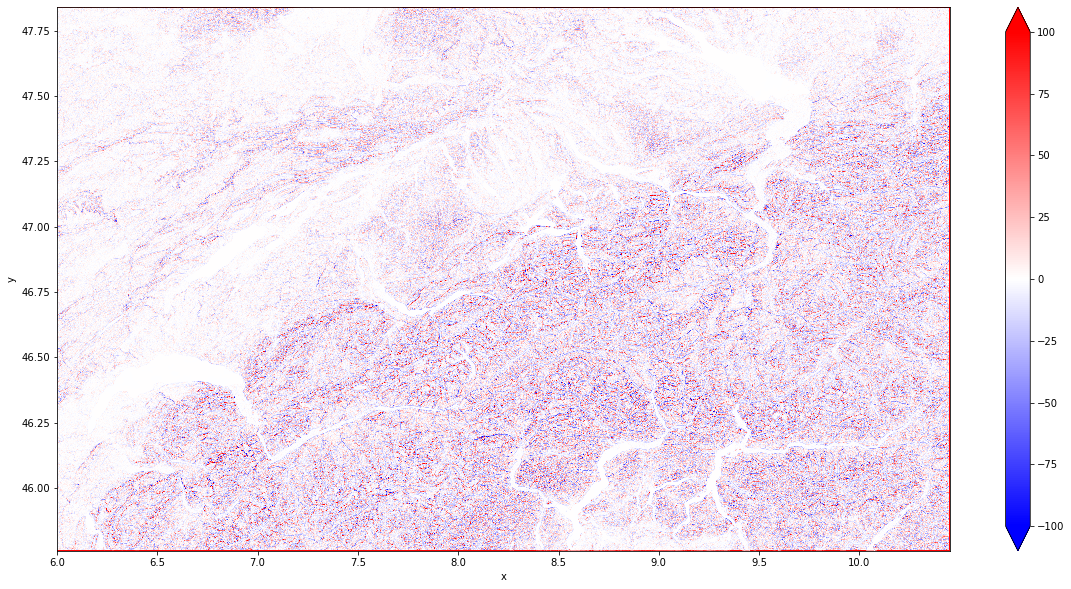

In [19]:
from topo_descriptors import topo, helpers

scale_meters = 500
scale_pixel, __ = helpers.scale_to_pixel(scale_meters, dem)
topo.tpi(dem, scale_pixel).plot(vmin=-100, vmax=100, cmap="bwr", figsize=(20,10))